In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [4]:
import numpy as np
import pandas as pd
from plotnine import *
from pulp import PULP_CBC_CMD
from wurlitzer import sys_pipes

from UCP.data import UCPData
import UCP.model as original_model
import UCP.output.check_solution as ck
from generic.optimization.dual.algorithms.cutting_plane import *
from generic.optimization.dual.algorithms.subgradient import *
from generic.optimization.dual.combined_algorithm import (
    AlgorithmConfiguration,
    BoundsTracker,
    CombinedAlgorithm,
    KpiCollector,
)
from generic.optimization.dual.combined_algorithm import charts as algo_charts
from generic.optimization.dual.combined_algorithm import extract_kpis, pretty_printer
from generic.optimization.solution_extraction import extract_solution
from generic.series_dict import series_dict_to_array
from UCP.output import charts
from UCP.relaxations.combinatorial_heuristic import combinatorial_heuristic
from UCP.relaxations.local_search_heuristic import local_search
from UCP.relaxations.lagrangian.production_state.relaxation import ProductionStateRelaxation
from UCP.relaxations.lagrangian.production_state.charts import constraints_violations 


In [5]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61), legend_position="right"))

$\newcommand{\var}[1]{{\color{blue}{#1}}}$
$\newcommand{\mult}[1]{{\color{red}{#1}}}$
$\newcommand{\EIE}{{\textrm{EIE}}}$
$\newcommand{\ENP}{{\textrm{ENP}}}$

# UCP with Lagrangian Decomposition

## Description
The original UCP problem is formulated as

$$
  \begin{align}
  \min & \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{it}} + c_{i} \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t} \notag \\
  \text{s.t.} ~~ & \underline{p}_i \var{s_{it}} \le \var{p_{it}} \le \bar{p}_i \var{s_{it}} & \forall i\in I, t\in T\\
       & \var{u^+_{it}} \ge \var{s_{it}} - \var{s_{i(t-1)}} & \forall i\in I, t\in T : t > 0\\
       & \var{u^-_{it}} \ge \var{s_{i(t-1)}} - \var{s_{it}} & \forall i\in I, t\in T : t > 0\\
       & \var{s_{it}} \ge \sum_{t'\in \max(0, t-\tau^+_i) \ldots t} \var{u^+_{it'}} & \forall i\in I, t\in T\\
       & \var{s_{it}} \le 1 - \sum_{t'\in \max(0, t-\tau^-_i) \ldots t} \var{u^-_{it'}} & \forall i\in I, t\in T \label{cons:orig-min-down}\\
       & \sum_{i\in I} \var{p_{it}} + \var{\ENP_{t}} = D_t + \var{\EIE_t} & \forall t\in T \\
       & \var{s_{it}}, \var{u^-_{it}}, \var{u^+_{it}} \in \{0, 1\}  & \forall i\in I, t\in T \label{cons:orig-bin-vars}\\
       & \var{p_{it}}, \var{\EIE_{t}}, \var{\ENP_{t}} \in \mathbb{R}^+_0 & \forall i\in I, t\in T
\end{align}
$$

### Relaxation
We then relax the minimum and maximum production constraints (1), separating the state/integer variables $s_{it}$ from the production/continuous variables $p_{it}$.

The relaxed constraints are re-introduced as penalties in the objective function weighted by lagrangian prices, $\lambda^+$ and $\lambda^-$ for the upper and lower bounds resp., yielding the objective function
$$ \begin{align*}
 \mathcal{L} (\mult{\lambda}, \var{x}) = \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{it}} + c_{i} \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t} + \mult{\lambda^+_{it}} (\var{p_{it}} - \bar{p}_{i} \var{s_{it}}) + \mult{\lambda^-_{it}} (\underline{p}_{i} \var{s_{it}} - \var{p_{it}}) \\
=  \sum_{i\in I, t\in T} \left ( (l_{i} + (\mult{\lambda^+_{it}} - \mult{\lambda^-_{it}})) \var{p_{it}} + (c_{i} - (\mult{\lambda^+_{it}} - \mult{\lambda^-_{it}})) \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t}
\end{align*}$$

where $\mult\lambda = [\mult{\bf{\lambda^+}}, \mult{\lambda^-}]$ is the price vector and $\var{\bf{x}} = [\var{\bf{s}}, \var{\bf{u^+}}, \var{\bf{u^-}}, \var{\bf{p}}, \var{\textbf{EIE}}, \var{\textbf{ENP}}]$ are the original variables.

**Note:** $\var{\bf{x}}$ are called in the literature "primal" variables while $\mult\lambda$ are called "dual" variables. The "primal" solutions are then values $\var{\bf{x}}$ that _can_ be:

* feasible for the original problem, which I call "full solutions" in the explanation
* infeasible for the original problem, e.g. computed from the subproblems (see below), which I call "partial solutions" in the explanation.

### Decomposition
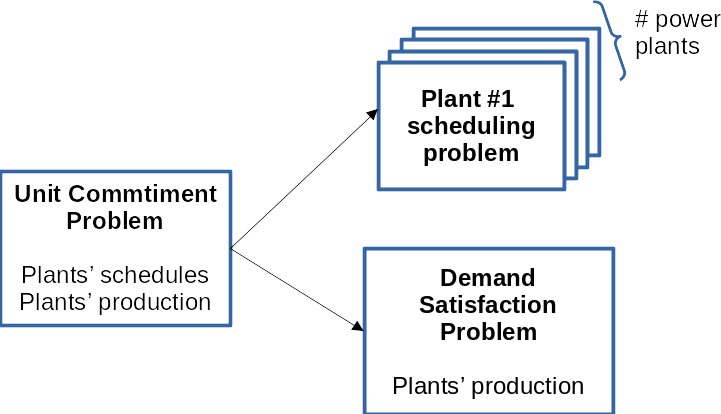
The relaxed problem decomposes into smaller, simpler problems, some of which are independent and thus can be solved in parallel.

* $|I|$ independent single-plant scheduling subproblems,  one for each power plant $i$, which compute the minimum cost schedules.<br>
   **Note:** each scheduling problem can be reduced to a shortest path problem and thus be solved directly with e.g. `networkx` methods.
  
  **Scheduling for plant $i$**
$$\begin{align*}
  \min & \sum_{t\in T} (c_{i} - \mult{\lambda^+_{it}} + \mult{\lambda^-_{it}}) \var{s_{it}} \notag \\
  \text{s.t.} ~~ & \var{u^+_{it}} \ge \var{s_{it}} - \var{s_{i(t-1)}} & \forall t\in T : t > 0\\
       & \var{u^-_{it}} \ge \var{s_{i(t-1)}} - \var{s_{it}} & \forall t\in T : t > 0\\
       & \var{s_{it}} \ge \sum_{t'\in \max(0, t-\tau^+_i) \ldots t} \var{u^+_{it'}} & \forall t\in T\\
       & \var{s_{it}} \le 1 - \sum_{t'\in \max(0, t-\tau^-_i) \ldots t} \var{u^-_{it'}} & \forall t\in T \label{cons:orig-min-down}\\
       & \var{s_{it}}, \var{u^-_{it}}, \var{u^+_{it}} \in \{0, 1\}  & \forall t\in T \label{cons:orig-bin-vars}
\end{align*}
$$

* one continuous "Demand Satisfaction" problem that computes the optimal production level of power plants to satisfy demand

  **Demand Satisfaction**
$$  \begin{align*}
  \min & \sum_{i\in I, t\in T}  (l_{i} + \mult{\lambda^+_{it}} - \mult{\lambda^-_{it}}) \var{p_{it}} + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t}\notag \\
  \text{s.t.} ~~ & \sum_{i\in I} \var{p_{it}} + \var{\ENP_{t}} = D_t + \var{\EIE_t} & \forall t\in T \\
  & \var{p_{it}}, \var{\EIE_{t}}, \var{\ENP_{t}} \in \mathbb{R}^+_0 & \forall i\in I, t\in T
\end{align*}$$

# Optimization with Lagrangian Decomposition
To compute good prices $\mult\lambda$ the Lagrangian Dual Problem D is solved:
$$ D : \max_{\mult{\lambda}\ge \bf{0}}\varphi(\mult\lambda) = \min_{\var{x} \in \mathcal{X}} \mathcal{L} (\mult\lambda, \var{x})$$

The lagrangian dual function $\varphi$ is the optimal value of the relaxed problem for a given vector of prices $\mult\lambda$ and is concave, piece-wise linear and non-smooth.

To optimize $\varphi$ subgradient-based methods are used. The subgradient of $\varphi$ at $\mult\lambda$ is given by the _"violation"_ of relaxed constraints for the corresponding relaxed solution $x_\lambda = \arg \min_{\var{\bf{x}}\in \mathcal{X}} \mathcal{L}(\mult{\bf{\lambda}}, \var{\bf{x}})$.

For the UCP the subgradient is:

* for $\mult{\lambda^+_{it}}$: $\dfrac{\partial{\varphi}}{\partial\mult{\lambda^+_{it}}}  = \var{p_{it}} - \bar{p}_i \var{s_{it}}$
* for $\mult{\lambda^-_{it}}$: $\dfrac{\partial{\varphi}}{\partial\mult{\lambda^-_{it}}}  = \underline{p}_i \var{s_{it}} - \var{p_{it}}$


## Subgradient Algorithms

We use two methods:
* Cutting Plane (CP): collects subgradients from solutions $(\mult{\lambda}, \var{\bf{x}})$ to construct a piece-wise linear approximation of the function $\varphi$. <br>
  For a linear problem $\varphi$ is indeed piece-wise linear, but with an exponential number of breakpoints.
* Subgradient Method (SM): like gradient-descent but with subgradients.

In general, CP is "global" in the sense that it makes the "most-improving" move according to its current approximation of $\varphi$ and thus tends to "move more", generating new solutions farther from the current one. Of course, as the LDF can be quite rough, the new solution is usually not as improving as expected, possibly worsening. Indeed, the dual bound computed by the method is non-monotonic and can exhibit a lot of zig-zagging.

The SM method is more "local" in the sense that its step size and directions are limited via parametrization, hence it usually generates solutions that are closer to the current one compared to the CP method.

We use the two methods in the following way:

1. perform $k_{\textrm{CP}}$ iterations of CP, (usually one) then
2. perform $k_{\textrm{SM}}$ iterations of SM, starting from the last CP solution

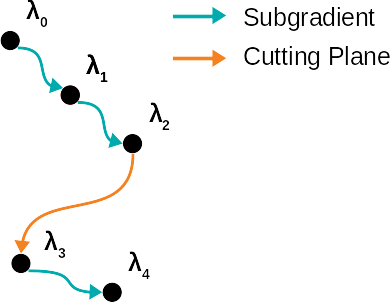

The combination of "local" and "global" methods results in a more effective algorithm than either alone as it provides a good balance between "exploitation" and "exploration", yielding a diverse and comprehensive selection of solutions and, thus, faster convergence and higher-quality final solutions.

# Full scheme

The structure of the algorithm is given in the picture:

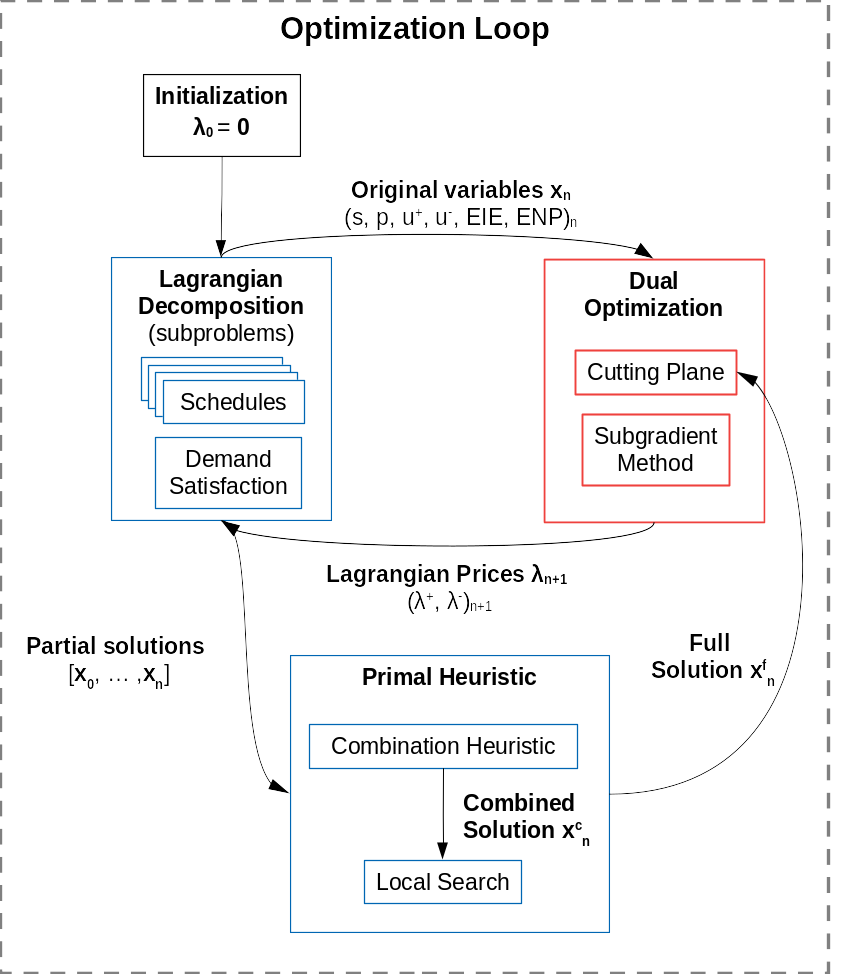

The main components are
* An optimization loop  with two steps:
  * Lagrangian decomposition: given current prices $\mult\lambda$ solves the relaxation to compute new partial solutions $\var{\bf{x}}$
  * Dual Optimization: given current partial solution $\var{\bf{x}}$ computes new prices $\mult\lambda$, using either the Cutting Plane or the Subgradient method
* A primal heuristic: given the list of partial solutions computed so far, generates a new solution $\var{\bf{x}}$, hopefully feasible and optimal for the original problem, using 
   * combination: for each power plant choose a schedule among the ones computed so far to minimise production cost.
   * local search: perform limited changes on the combined solution to further reduce its cost.<br>
     The location and "radius" of the search depends on the "energy prices" (lagrangian prices of constraint, computed cheaply via MILP solvers).
   * both steps in the heuristic use MILP models.
   * The subgradient of the new  full solution $x^f_n$ is then added to the Cutting Plane model as well to "enrich" its approximation of $\varphi$.

## Algorithm

1. Initialization. $n=0$; set multipliers to a value. For simpicity here we set $\lambda_0=0$ but better methods are usually considered.
2. Step: performa an optimization loop:  
   1. compute new variables $x_n = \arg \min_{\var{\bf{x}}\in \mathcal{X}} \mathcal{L}({\lambda_n}, \var{\bf{x}})$
   2. compute new multipliers $\lambda_{n+1}$ using dual optimization
3. Run the primal heuristic, possibly only every $m$ steps, yielding a new full solution.
4. If iteration limit is reached ($n = \bar{n}$) or optimality gap is below threshold (see below) stop.<br>
   Otherwise $n := n+1$ and go to #2

## Bounds and optimality gap 


Let $\var{\bf{x}}\in \mathcal{X}$ be a partial solution. At each step $n$, we consider the following (global) bounds:

* dual $B^D_n$: the best known value of the lagrangian dual $\max_{n'\in 1\ldots n} \varphi(\mult{\lambda_{n'}})$
* primal $B^P_n$: the best known value of the full solutions *that are feasible*: $\min_{n'\in 1\ldots n} \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{it}} + c_{i} \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t}$ if $ \underline{p}_i {\var{s_{itn'}}} \le \var{p_{itn'}} \le \bar{p}_i \var{s_{itn'}}$

The optimal value of the original problem $\textrm{opt}(P)$ is between these two bounds:
$$B^D_n \le \textrm{opt}(P) \le B^P_n$$

As the number of iterations grow, the global bounds get closer and closer. <br>
For convex problems the two bounds converge to the same value: the optimal value of P $\textrm{opt}(P)$.<br>
For mixed-integer/non-convex problems the dual converges to a lower (for min problems) value than the optimal value of the original problem P, living a gap from P's optimum called _"duality gap"_.


The optimality gap is the percentage difference between $B^D_n$ and $B^P_n$ and estimates the potential improvement for the current best primal solution.
$$\mathrm{gap}_n = 100 \frac{B^P_n - B^D_n}{B^P_n}$$

Then, an often used stopped criterion for the Optimization Loop is when the gap is below a certain threshold $\epsilon$, i.e. when the current solution's potential improvement becomes negligible. Usually $1\% \le \epsilon \le 5\%$

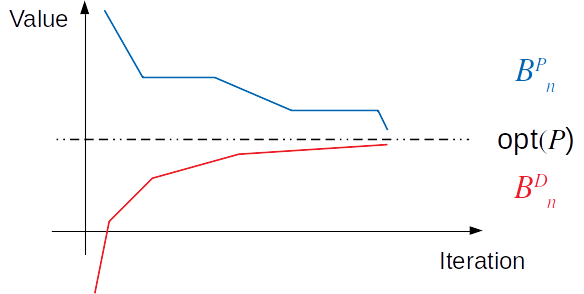

In [6]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

## Full optimization with Solver

In [7]:
ucp = original_model.create_model(data)
ucp.model.solve(solver=PULP_CBC_CMD(mip=1, options=["node depth seconds 180"], msg=0))

optimal_cost = optimal_value = ucp.model.objective.value()

In [8]:
print(f"Cost: {optimal_cost:15.5g}")

Cost:      1.3913e+05


## Setup

In [9]:
relaxation = ProductionStateRelaxation(data)

var_lb, var_ub = tuple(
    series_dict_to_array(**m)
    for m in relaxation.multipliers_range()
)

## Subgradient
### Target tracking for the subgradient

Target tracking means over-estimating the optimal value of $\varphi$, as we are maximizing it, to determine the step-size for the subgradient algorithm.

We adopt the following policy:
* We get an upper bound of the optimal value from the current Full Solution (FS), via the `bounds_tracker`, which tracks the best bounds for the whole algorithm.
* If the current FS value is close to the current value of $\varphi$ then our multipliers are good and we are close to the optimum, then we need to make smaller steps.
   * We assume that if the two values differ less than 20%, they're close.
   * if the FS has not been computed yet, its value is set to +infinity, thus ignored
* Otherwise we take the maximum between:
    * the `fixed_tracker` value, which is the best $\varphi$ value seen so far (best dual bound) over-estimated by 25%.
    * the `lower_cost_estimate`, which is the minimum possible cost of energy, i.e. the cost of demand if we used the cheapest power plant.
    
  the rationale is that at the beginning the best $\varphi$ value can be very low, even lower than  the `lower_cost_estimate`. The latter can thus provide a better upper bound estimate and thus larger step-sizes.

In [10]:
upper_bound = np.nan

lower_cost_estimate = data.loads["value"].sum() * data.thermal_plants["l_cost"].min()

fixed_tracker = FixedTargetTracker(sense=-relaxation.sense, overestimation_factor=0.25)

bounds_tracker = BoundsTracker(sense=relaxation.sense)

def target_tracker(current_lf_value: float) -> float:
    upper_bound = bounds_tracker.best_primal_solution.objective
    if abs(upper_bound - current_lf_value) / abs(current_lf_value + 1e-3) > 0.2:
        fixed_target = fixed_tracker(current_lf_value)
        result = max(fixed_target, lower_cost_estimate)
    else:
        result = upper_bound
    return result

In [11]:
sgd_algorithm_conf  = dict(
            sense=-relaxation.sense,
            var_lb=var_lb,
            var_ub=var_ub,
            step_size_fun=PolyakStepSizeRule(-relaxation.sense, target_tracker),
            deflection_fun=make_CFMDeflection(),
        )

## Cutting Plane

In [12]:
cp_algorithm_config = dict(sense=-relaxation.sense, var_lb=var_lb, var_ub=var_ub)

## Primal Heuristic

In [13]:
def run_heuristic(partial_solutions):
    solver_options = ["ratio", "0.05", "sec", "40", "doh", "node depth", "msg", "0"]
    commitments = [ps["s"] for ps in partial_solutions]
    solution = combinatorial_heuristic(
        data,
        commitments,
        combination_options=dict(
            mip=0, options=solver_options
        ),
    )
    solution = local_search(data, solution, options=solver_options)
    print(
        f" => Heuristic:\tTotal cost: {solution['total_production_cost']:15.5g}\t"
        + f"Demand mismatch cost:{solution['demand_mismatch_cost']:15.5g}"
    )
    return relaxation.information_from_primal_solution(solution)

## Initialization

In [14]:
configuration = AlgorithmConfiguration(
    primal_feasibility_tolerance=1e-4,
    subgradient_tolerance=1e-6,
    sgd_iterations=4,
    cp_iterations=1,
    heuristic_frequency=6,
    max_gap=0.025,
    max_cp_gap=0.01,
    relaxation_solver_options={},
    cp_solver_options={"options": ["seconds 60"]},
    max_iterations=24,
    sgd_name="Polyak+CFM",
    cp_name="CPM",
)

In [15]:
initial_multipliers = relaxation.fill_multipliers(0.0)

bounds_tracker.reset()
fixed_tracker.reset()

combined_algorithm = CombinedAlgorithm(
    configuration,
    relaxation,
    initial_multipliers,
    cp_algorithm_config,
    sgd_algorithm_conf,
    run_heuristic,
    bounds_tracker=bounds_tracker,
)

## Execution

In [16]:
kpi_collector = KpiCollector()
print(pretty_printer.header() + f"|{'Gap% from Optimum*':>18}")
stop = False
while not stop:
    stop = combined_algorithm()
    kpi_collector.collect(combined_algorithm)
    print(
        pretty_printer.row(kpi_collector)
        + f"|{abs(1- (bounds_tracker.best_primal_solution.objective/optimal_value)):>18.2%}"
    )

| It.|Dual Algorithm| Current Dual|  Current Master|    Best Dual|  Best Primal|   Best Master| Optimality Gap%|   CP Gap%|Gap% from Optimum*
|   0|          None|   1.1202e+05|             inf|   1.1202e+05|          inf|           inf|         100.00%|   100.00%|              inf%
|   1|    Polyak+CFM|   1.2217e+05|             inf|   1.2217e+05|          inf|           inf|         100.00%|   100.00%|              inf%
|   2|    Polyak+CFM|   1.3052e+05|             inf|   1.3052e+05|          inf|           inf|         100.00%|   100.00%|              inf%
|   3|    Polyak+CFM|   1.3111e+05|             inf|   1.3111e+05|          inf|           inf|         100.00%|   100.00%|              inf%
|   4|    Polyak+CFM|   1.3133e+05|             inf|   1.3133e+05|          inf|           inf|         100.00%|   100.00%|              inf%
|   5|           CPM|   -5.918e+05|      5.9044e+05|   1.3133e+05|          inf|    5.9044e+05|         100.00%|    77.76%|              inf%


Local Search => Current cost: 1.5e+05. Demand mismatch cost:4.6e+03
Local Search => New cost: 1.4e+05.New demand mismatch cost:2.2e+02. Improvement: 2.74%


 => Heuristic:	Total cost:      1.4229e+05	Demand mismatch cost:          218.8
|   6|    Polyak+CFM|  -3.4329e+05|      5.9044e+05|   1.3133e+05|   1.4229e+05|    5.9044e+05|           7.71%|    77.76%|             2.28%
|   7|    Polyak+CFM|  -1.8105e+05|      5.9044e+05|   1.3133e+05|   1.4229e+05|    5.9044e+05|           7.71%|    77.76%|             2.28%
|   8|    Polyak+CFM|       -92934|      5.9044e+05|   1.3133e+05|   1.4229e+05|    5.9044e+05|           7.71%|    77.76%|             2.28%
|   9|    Polyak+CFM|       -34223|      5.9044e+05|   1.3133e+05|   1.4229e+05|    5.9044e+05|           7.71%|    77.76%|             2.28%
|  10|           CPM|   -6.068e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  11|    Polyak+CFM|  -3.7264e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%


Local Search => Current cost: 1.7e+05. Demand mismatch cost:4e+04
Local Search => New cost: 1.5e+05.New demand mismatch cost:1.5e+04. Improvement: 11.48%


 => Heuristic:	Total cost:      1.5253e+05	Demand mismatch cost:          15119
|  12|    Polyak+CFM|  -2.3434e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  13|    Polyak+CFM|  -1.0395e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  14|    Polyak+CFM|       -62521|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  15|           CPM|  -2.9334e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  16|    Polyak+CFM|  -2.4486e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  17|    Polyak+CFM|  -1.8166e+05|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%


Local Search => Current cost: 1.9e+05. Demand mismatch cost:6.2e+04
Local Search => New cost: 1.7e+05.New demand mismatch cost:3.5e+04. Improvement: 11.08%


 => Heuristic:	Total cost:      1.6572e+05	Demand mismatch cost:          35362
|  18|    Polyak+CFM|       -48971|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  19|    Polyak+CFM|       -33648|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  20|           CPM|        64565|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  21|    Polyak+CFM|        76047|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  22|    Polyak+CFM|        78816|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%
|  23|    Polyak+CFM|        92067|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%


Local Search => Current cost: 1.5e+05. Demand mismatch cost:2e+04
Local Search => New cost: 1.4e+05.New demand mismatch cost:6.2e+03. Improvement: 6.86%


 => Heuristic:	Total cost:      1.4431e+05	Demand mismatch cost:         6170.7
|  24|    Polyak+CFM|        81814|      1.4229e+05|   1.3133e+05|   1.4229e+05|    1.4229e+05|           7.71%|     7.71%|             2.28%


\* **Note:** the column 'Gap% from Optimum*' is reported here only for sake of explanation as in most settings the true value of the optimum is not known beforehand.

## Output

In [17]:
kpis = kpi_collector.table().reset_index()

### Feasibility/Constraints Violations

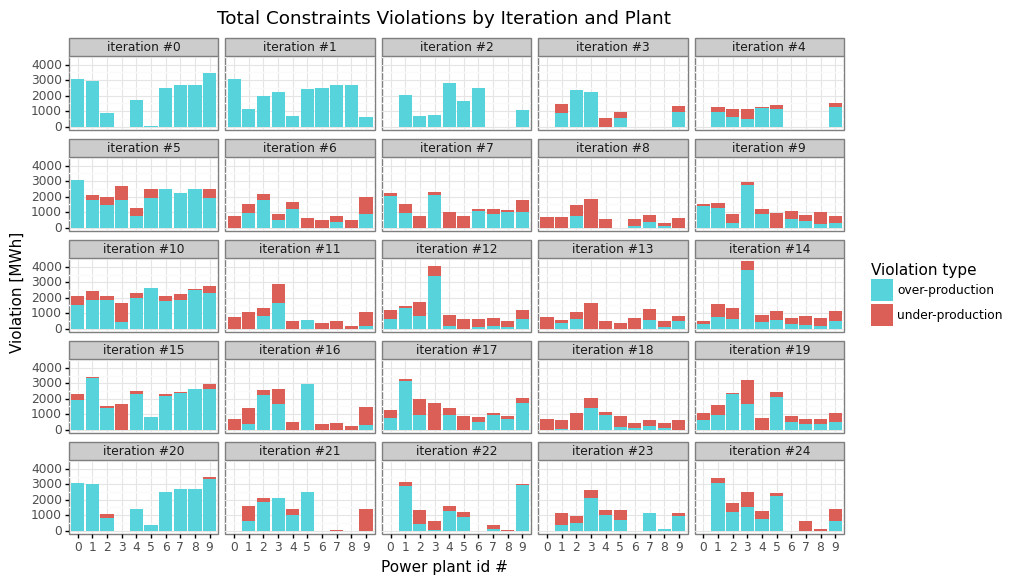

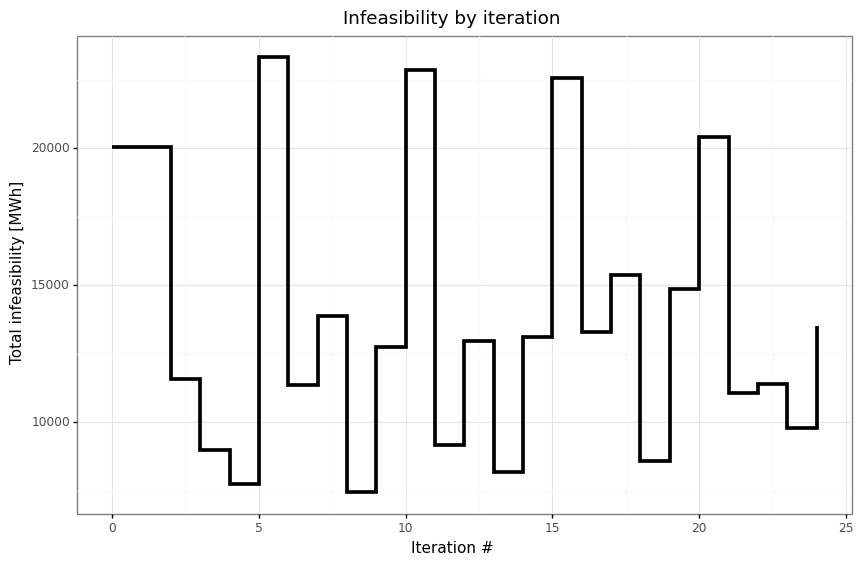

In [18]:
subproblem_solutions = (
    kpis["relaxation_primal"].apply(lambda r: r.solution).to_list()
)

print(constraints_violations(data, subproblem_solutions))
print(algo_charts.infeasibility(kpis))

### Optimality KPIs

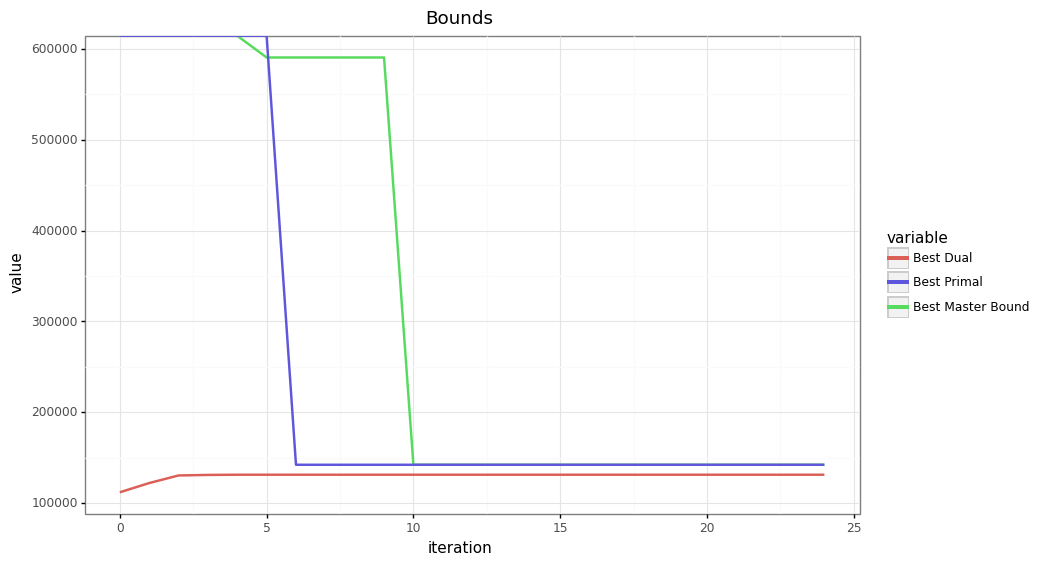

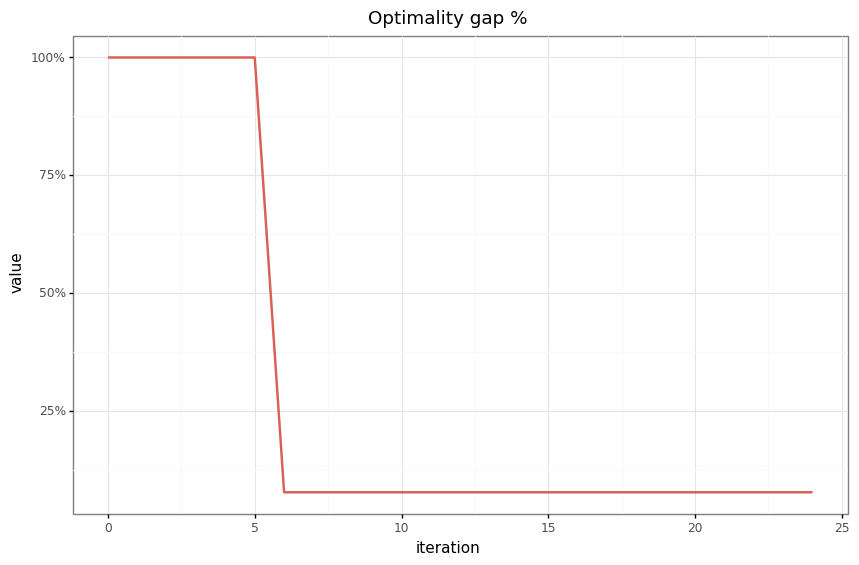

In [19]:
print(algo_charts.bounds(kpis))
print(algo_charts.gap(kpis))

### Final Solution

In [20]:
solution = bounds_tracker.best_primal_solution.solution

#### Checking feasibility.

This step is not needed because the method produces feasible solutions by construction. The check is performed anyway for illustration purposes.

In [21]:
feasible, analysis = ck.check_solution(data, solution)

if feasible:
    print("Solution is feasible, all OK")
else:
    print("Solution is infeasible!")

Solution is feasible, all OK


### UCP plots

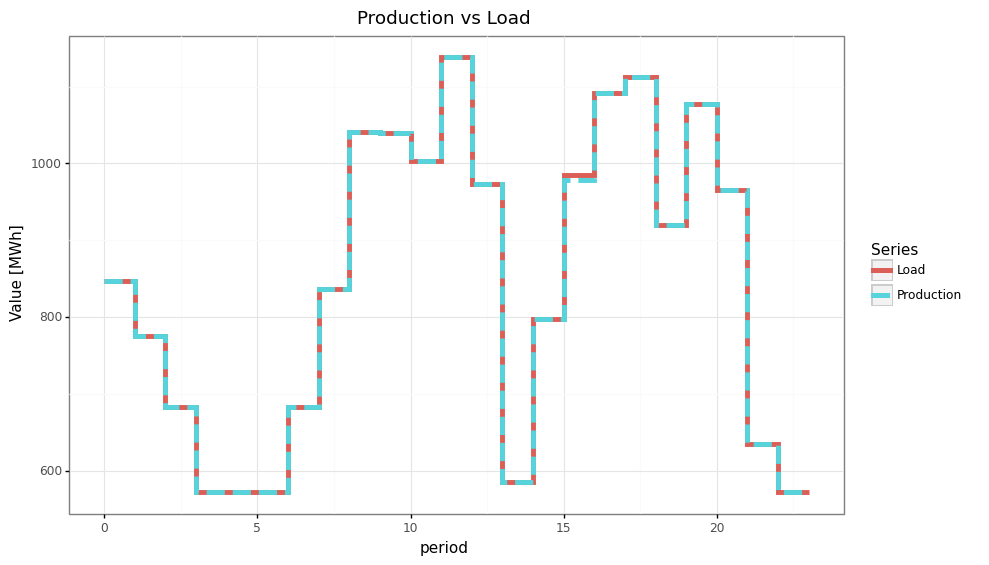

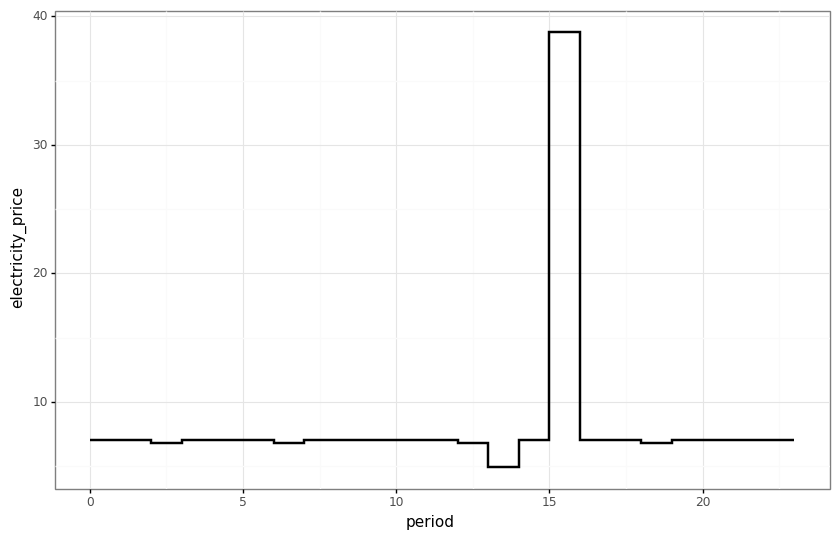

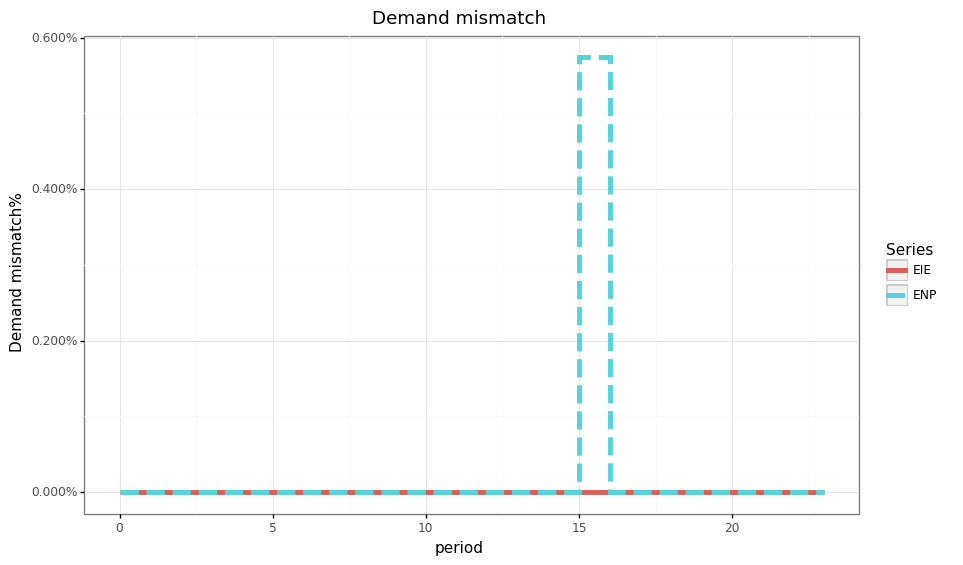

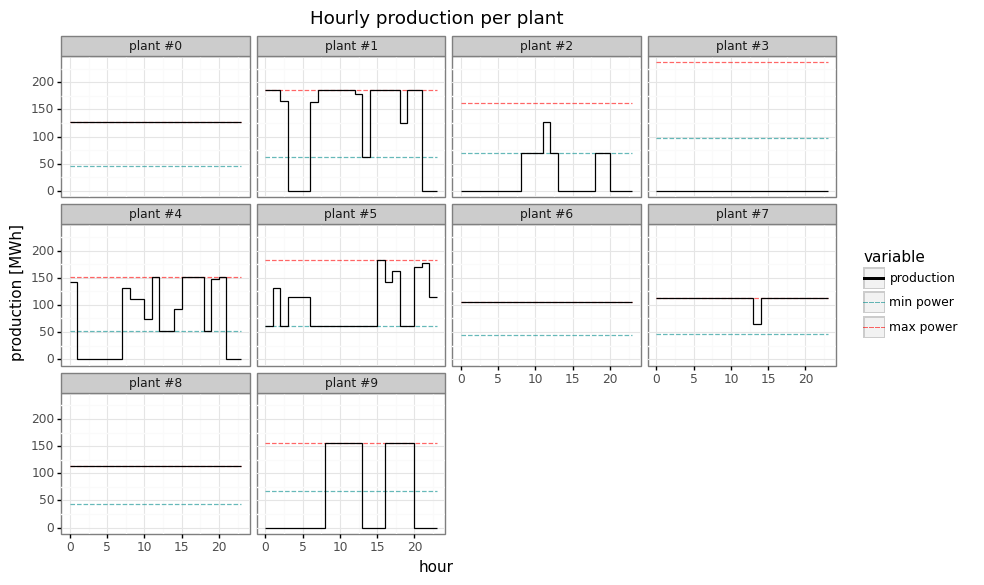

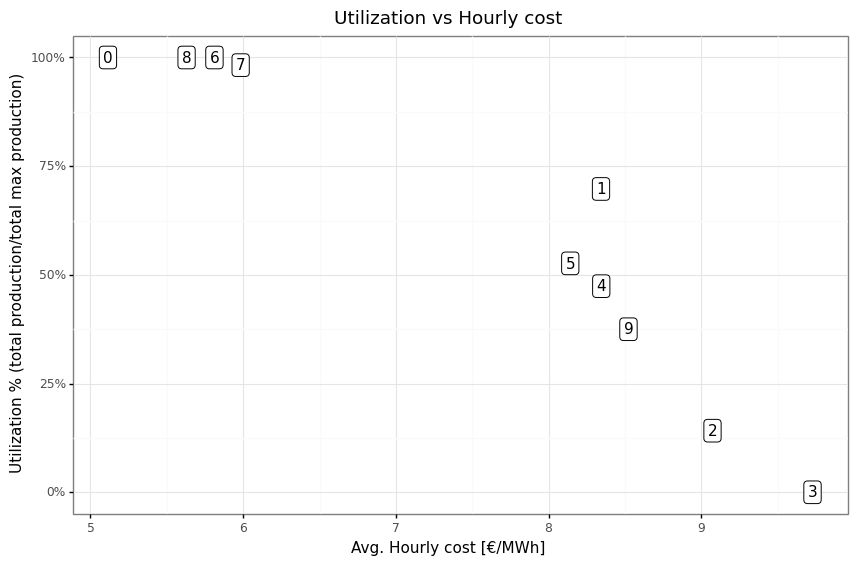

In [22]:
plots = [
    charts.total_production(data, solution),
    charts.electricity_prices(data, solution),
    charts.enp_vs_eie(data, solution),
    charts.production_by_plant(data, solution),
    charts.plant_utilization(data, solution),
]

for p in plots:
    print(p)